<a href="https://colab.research.google.com/github/shashwat9kumar/ML-And-DataScience/blob/master/Tensorflow/04_Transfer_learning_in_tensorflow_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transer Learning with Tensorflow Part 1: Feature Extraction


Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problems

There are 2 main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our
2. Can leverage a working neural network architecture which is already learned patterns on similar data to our own, then we can adapt those patterns to our own data


In [1]:
# Are we using a gpu?
!nvidia-smi

Wed Jun  9 16:04:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from FOOD101)

import zipfile


# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-06-09 16:04:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 64.233.167.128, 64.233.166.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  42.4MB/s    in 3.8s    

2021-06-09 16:04:34 (42.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# walk through 10 percent data directory and list the files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in `{dirpath}`")

There are 2 directories and 0 images in `10_food_classes_10_percent`
There are 10 directories and 0 images in `10_food_classes_10_percent/train`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/ice_cream`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/hamburger`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/fried_rice`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/ramen`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/sushi`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/steak`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/chicken_curry`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/grilled_salmon`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/pizza`
There are 0 directories and 75 images in `10_food_classes_10_percent/train/chicken_wing

## Creating data loaders (preparing the data)

We'll use the ImageDataGenerator class to load in our images in batches

In [4]:
# Set up the data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE=32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode='categorical')

print("Testing Images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode='categorical')

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)


Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the Tensorboard callback
* Model checkpoint with ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callbacks



In [5]:
# Create a Tensorboard callback ( functionize it because we need to create a new one 
# each time we create a new model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving Tensorboard log files to: {log_dir}")
    return tensorboard_callback


We have customized the directory where our TensorBoard logs (model training metrics) get saved to whereever we like

## Creating model using TensorFlow Hub


In the past we have used tensorflow to create models layer by layer from scratch.

Now were going to do a very similar process, just except the majority of our model's layers are going to  come from Tensorflow Hub

We can access the pretrained models on: https://tfhub.dev/

Browsing the Tensorflow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following 2 models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
    """
    Takes a tensorflow hub url and creates a Keras Sequential model with it

    Args:
        model_url (str): A tensorlow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer, should be
                            equal to the number of target classes, default 10.
    
    Returns:
        An uncompiled Keras Sequential model with model url as feature extractor 
        layer and Dense layer with num_classes output neuron
    """

    # Download the pretrained model and save it as a Keras Layer

    feature_extractor_layer = hub.KerasLayer(model_url, 
                                             trainable=False,  # Freeze the already learned patterns
                                             name = "feature_extraction_layer",
                                             input_shape = IMAGE_SHAPE+(3,)) 
    
    # create our own model
    model = tf.keras.Sequential(
        [
         feature_extractor_layer,
         layers.Dense(num_classes, activation="softmax", name="output_layer")
        ]
    )

    return model

### Creating and testing Resnet Tensorflow Hub Feature Extraction model

In [9]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
# Let's fit our resnet model to our data (10 percent of the classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/20210609-160450
Epoch 1/5
24/24 [==============================] - 49s 750ms/step - loss: 1.9858 - accuracy: 0.3360 - val_loss: 1.2420 - val_accuracy: 0.6036
Epoch 2/5
24/24 [==============================] - 16s 682ms/step - loss: 0.9495 - accuracy: 0.7027 - val_loss: 0.8768 - val_accuracy: 0.7216
Epoch 3/5
24/24 [==============================] - 16s 682ms/step - loss: 0.6583 - accuracy: 0.8040 - val_loss: 0.7588 - val_accuracy: 0.7608
Epoch 4/5
24/24 [==============================] - 16s 685ms/step - loss: 0.5002 - accuracy: 0.8467 - val_loss: 0.7075 - val_accuracy: 0.7776
Epoch 5/5
24/24 [==============================] - 16s 672ms/step - loss: 0.4094 - accuracy: 0.8880 - val_loss: 0.6673 - val_accuracy: 0.7872


WOW!!!!!!!!


That is incredible. Out transfer learning feature extractor model outperformed all of the previous models we built by hand .. (substantially) and in a quicker training time and only on 10 percent of the training data

In [17]:
# Lets create a function to plot our loss curves...
# Tidbit: you can put a function like this in a script like "helper.py" and import it and when needed

import matplotlib.pyplot as plt

# plot validation and training curves
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics

    Args:
        history: TensorFlow history object

    Returns:
        Plots of Training/validation loss and accuracy metrics
    """

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    #Plot loss
    plt.plot(epochs, loss, label="Training_Loss")
    plt.plot(epochs, val_loss, label="Validation_Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="Training_Accuracy")
    plt.plot(epochs, val_accuracy, label="Validation_Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

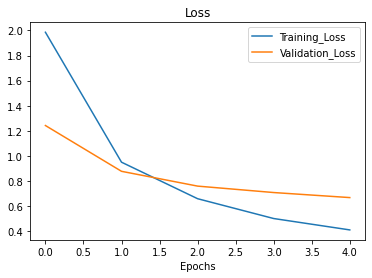

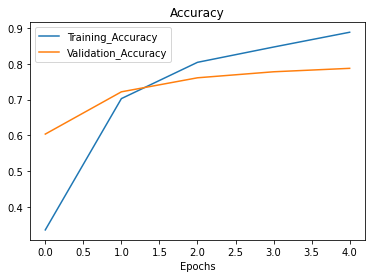

In [18]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [20]:
# Create Efficient net feature extractor model
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                            optimizer = tf.keras.optimizers.Adam(),
                            metrics=["accuracy"])

efficientnet_histroy = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20210609-163127
Epoch 1/5
24/24 [==============================] - 30s 915ms/step - loss: 1.8187 - accuracy: 0.4640 - val_loss: 1.2564 - val_accuracy: 0.7376
Epoch 2/5
24/24 [==============================] - 16s 701ms/step - loss: 1.0403 - accuracy: 0.7693 - val_loss: 0.8535 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 16s 689ms/step - loss: 0.7590 - accuracy: 0.8253 - val_loss: 0.6938 - val_accuracy: 0.8356
Epoch 4/5
24/24 [==============================] - 16s 694ms/step - loss: 0.6110 - accuracy: 0.8573 - val_loss: 0.6102 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 16s 687ms/step - loss: 0.5172 - accuracy: 0.8840 - val_loss: 0.5598 - val_accuracy: 0.8632


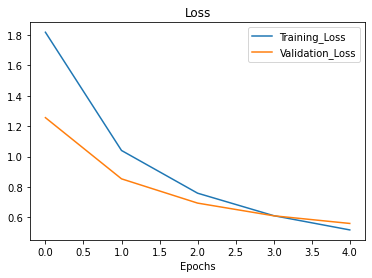

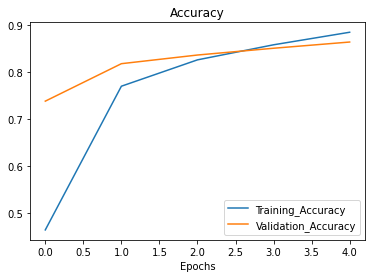

In [21]:
plot_loss_curves(efficientnet_histroy)

In [22]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [23]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)  ## weights = patterns of numbers

309

## Different Types of Transfer Learning

* **As is** transfer learning - using an existing with no changes whatsoever (eg. using Imagenet model on 1000 ImageNet classes, none of our own)
* **feature extraction** transfer learning - use the patterns of an existing model (eg. EfficentNet trained on Imagenet) and adjust the output layer for your own problem (eg. 1000 classes -> 10 classes of food) {what we have done till now}
* **Fine Tuning** Transfer Learning - use the pretrained patterns of an existing model and "fine-tune" many or all of the underlying layers (including output layers)

## Comparing our models result using TensorBoard

> Note: When you upload thinhs to Tensorboard.dev, your experiments are public. So if you're running private experiments (things you dont want others to see) Do not upload them to TensorBoard.dev

In [28]:
# Upload Tensorboard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
    --name "EfficientNetB0 vs ResNet50V2" \
    --description " Comparing 2 different TF hub feature extraction model architecture usinh 10% of the training data" \
    --one_shot

2021-06-09 16:57:57.542112: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2

Our tensorboard experiments are uploaded publicly here:
https://tensorboard.dev/experiment/hK1Y7cXPRpqBOzIA3jpMPw/

In [29]:
# Checkout what TensorBoard experiments you have
!tensorboard dev list

2021-06-09 17:03:56.852301: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/hK1Y7cXPRpqBOzIA3jpMPw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description           Comparing 2 different TF hub feature extraction model architecture usinh 10% of the training data
	Id                   hK1Y7cXPRpqBOzIA3jpMPw
	Created              2021-06-09 16:58:43 (5 minutes ago)
	Updated              2021-06-09 16:58:46 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5963064
Total: 1 experiment(s)


In [30]:
# Delete an experiment
# !tensorboard dev delete --experiment_id hK1Y7cXPRpqBOzIA3jpMPw

In [31]:
# Confirm the deletion by rechecking what experiments we have
!tensorboard dev list

2021-06-09 17:05:48.783408: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/hK1Y7cXPRpqBOzIA3jpMPw/
	Name                 EfficientNetB0 vs ResNet50V2
	Description           Comparing 2 different TF hub feature extraction model architecture usinh 10% of the training data
	Id                   hK1Y7cXPRpqBOzIA3jpMPw
	Created              2021-06-09 16:58:43 (7 minutes ago)
	Updated              2021-06-09 16:58:46 (7 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5963064
Total: 1 experiment(s)
